In [114]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from time import time
import transliterate
from pymystem3 import Mystem
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tqdm import tqdm_notebook
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import pickle

from training_utils import perplexity

In [127]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, GlobalAveragePooling1D, Dropout, Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop

# Load data

In [9]:
df = pd.read_csv('dialogs_1.csv')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
with open('extracted_stopwords.txt','r') as f:
    ru_stopwords = map(lambda s: s.replace('\n',''), f.readlines())
    ru_stopwords = set(ru_stopwords)

In [45]:
import transliterate
from pymystem3 import Mystem
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
    '''
# tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
tokenizer = RegexpTokenizer(pattern)

mystem = Mystem()
def clean_and_normalize_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = text.replace('x', ' ')
    text = mystem.lemmatize(text)
    text = tokenizer.tokenize(' '.join(text))
    text = map(lambda word: transliterate.translit(word,'ru'), text)
    text = filter(lambda w: w not in ru_stopwords,text)
    return ' '.join(list(text))


In [38]:
def split_sentences(st):
    sentences = re.split(r'[.?!]\s*', st)
    if sentences[-1]:
        return sentences
    else:
        return sentences[:-1]

# Extract and clean support responses 

In [23]:
support_responses = df[df['Тип'] =='1-ответ']['Контент'].dropna()

In [40]:
corpora = []
for resp in support_responses:
    corpora.extend(split_sentences(resp))

In [47]:
pool = Pool(cpu_count())
corpora = [resp for resp in tqdm_notebook(pool.imap_unordered(clean_and_normalize_text,corpora), total=len(corpora))]
pool.close()
pool.join()

In [50]:
from collections import Counter
word_count = Counter()
for resp in tqdm_notebook(corpora):
    for word in resp.split():
        word_count[word] +=1

# Some stats

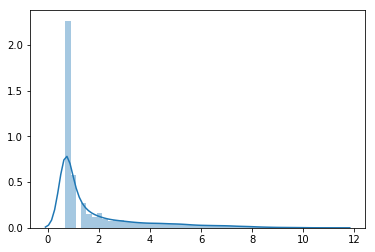

In [58]:
sns.distplot(np.log1p(list(word_count.values())))

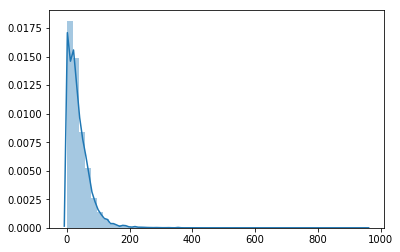

In [62]:
sns.distplot(list(map(len,corpora)))

# Preparing corpora for language modeling

In [85]:
MIN_LENGTH = 2
MAX_LENGTH = 180
VOCAB_SIZE = 10000 

In [100]:
freq_words = set([word for word,_  in word_count.most_common(5000)])

In [101]:
train_corpora = [[word for word in sent.split() if word in freq_words] for sent in corpora]

In [102]:
train_corpora = list(filter(lambda sent: len(sent)> MIN_LENGTH, train_corpora))

#### Model will predict probability of the next word in each support response

In [106]:
X, y = [],[]
for sent in train_corpora:
    for i,word in enumerate(sent):
        if i>0:
            X.append(sent[:i])
            y.append(word)

In [107]:
X = [' '.join(sent) for sent in X]

In [112]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Prep Word Indexer: assign each word a number
indexer = Tokenizer(lower=False, filters='', num_words=VOCAB_SIZE)
indexer.fit_on_texts(X) 

# Convert each word in sent to num and zero pad
X_seqs = pad_sequences(sequences=indexer.texts_to_sequences(X), 
                           maxlen=MAX_LENGTH, padding='post', truncating='post')

In [132]:
from keras.utils import to_categorical

# Save indexer for reproducibility

In [115]:
with open('keras_indexer.pkl','wb') as f:
    pickle.dump(indexer, f)

In [136]:
y_encoded =  list(map(lambda w:indexer.word_index[w] if w in indexer.word_index else 0,y))

In [146]:
def batch_generator(X,y, batch_size):
    X_batch, y_batch = [],[]
    for i, (data, target) in enumerate(zip(X,y)):
        X_batch.append(data)
        y_batch.append(target)
        if (i+1) % batch_size ==0:
            yield np.stack(X_batch), to_categorical(y_batch, VOCAB_SIZE)
            X_batch, y_batch = [],[]
    yield np.stack(X_batch), to_categorical(y_batch, VOCAB_SIZE)

# Training

In [129]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=32, input_length=MAX_LENGTH, mask_zero=True))
model.add(LSTM(128, input_shape=(MAX_LENGTH, VOCAB_SIZE)))
model.add(Dense(VOCAB_SIZE))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             1290000   
_________________________________________________________________
activation_1 (Activation)    (None, 10000)             0         
Total params: 1,692,432
Trainable params: 1,692,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size=128
model.fit_generator(batch_generator(X_seqs, y_encoded, batch_size), 
                    steps_per_epoch=int(np.ceil(len(X_seqs)/batch_size)), epochs=100, verbose=1)

In [148]:
model.save('language_model.h5')